In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')

In [2]:
ts = pd.read_csv('./daily-minimum-temperatures-in-me.csv', 
                 index_col=0, parse_dates=True)
ts.head()

,Daily minimum temperatures
Date,
1981-01-01,20.7
1981-01-02,17.9
1981-01-03,18.8
1981-01-04,14.6
1981-01-05,15.8


In [3]:
ts.shape

(3650, 1)

In [4]:
ts.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3650 entries, 1981-01-01 to 1990-12-31
Data columns (total 1 columns):
 #   Column                      Non-Null Count  Dtype 
---  ------                      --------------  ----- 
 0   Daily minimum temperatures  3650 non-null   object
dtypes: object(1)
memory usage: 57.0+ KB


In [5]:
ts['Daily minimum temperatures'].value_counts()

11      51
10      51
13      48
10.5    44
12.5    44
        ..
?0.2     1
24       1
25.2     1
22.7     1
21.6     1
Name: Daily minimum temperatures, Length: 230, dtype: int64

In [6]:
ts['Daily minimum temperatures']=ts['Daily minimum temperatures'].transform(lambda x : None if '?' in x else float(x))

In [7]:
ts.dropna(subset=['Daily minimum temperatures'], axis=0, inplace=True)

In [8]:
ts['Daily minimum temperatures'].info()

<class 'pandas.core.series.Series'>
DatetimeIndex: 3647 entries, 1981-01-01 to 1990-12-31
Series name: Daily minimum temperatures
Non-Null Count  Dtype  
--------------  -----  
3647 non-null   float64
dtypes: float64(1)
memory usage: 57.0 KB


In [9]:
ts['Daily minimum temperatures']

Date
1981-01-01    20.7
1981-01-02    17.9
1981-01-03    18.8
1981-01-04    14.6
1981-01-05    15.8
              ... 
1990-12-27    14.0
1990-12-28    13.6
1990-12-29    13.5
1990-12-30    15.7
1990-12-31    13.0
Name: Daily minimum temperatures, Length: 3647, dtype: float64

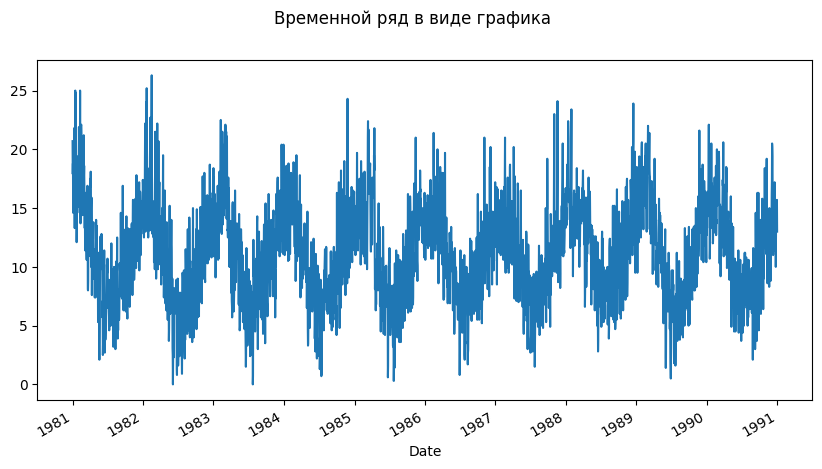

In [10]:
# визуализация
fig, ax = pyplot.subplots(1, 1, sharex='col', sharey='row', figsize=(10,5))
fig.suptitle('Временной ряд в виде графика')
ts.plot(ax=ax, legend=False)
pyplot.show()

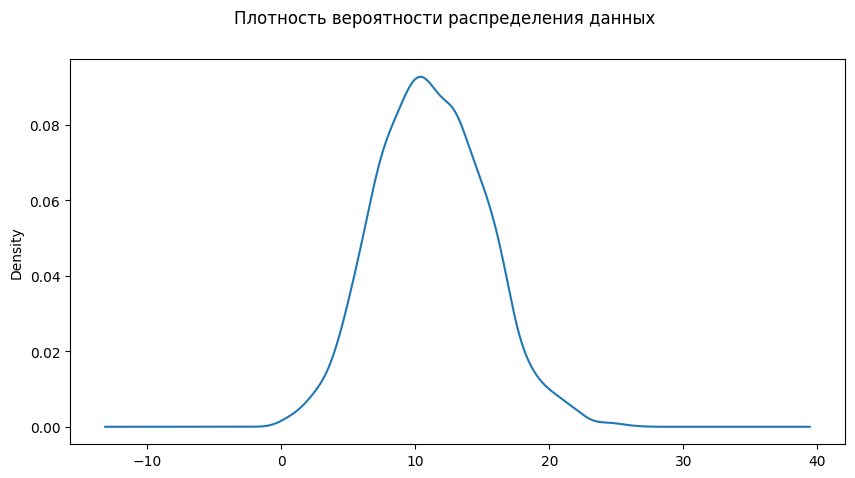

In [11]:
fig, ax = pyplot.subplots(1, 1, sharex='col', sharey='row', figsize=(10,5))
fig.suptitle('Плотность вероятности распределения данных')
ts.plot(ax=ax, kind='kde', legend=False)
pyplot.show()

In [12]:
from statsmodels.tsa.seasonal import seasonal_decompose
# Аддитивная модель
def plot_decompose(data, model='add'):
    result_add = seasonal_decompose(data, model = 'add', period=10)
    fig = result_add.plot()
    fig.set_size_inches((10, 8))
    # Перерисовка
    fig.tight_layout()
    plt.show()

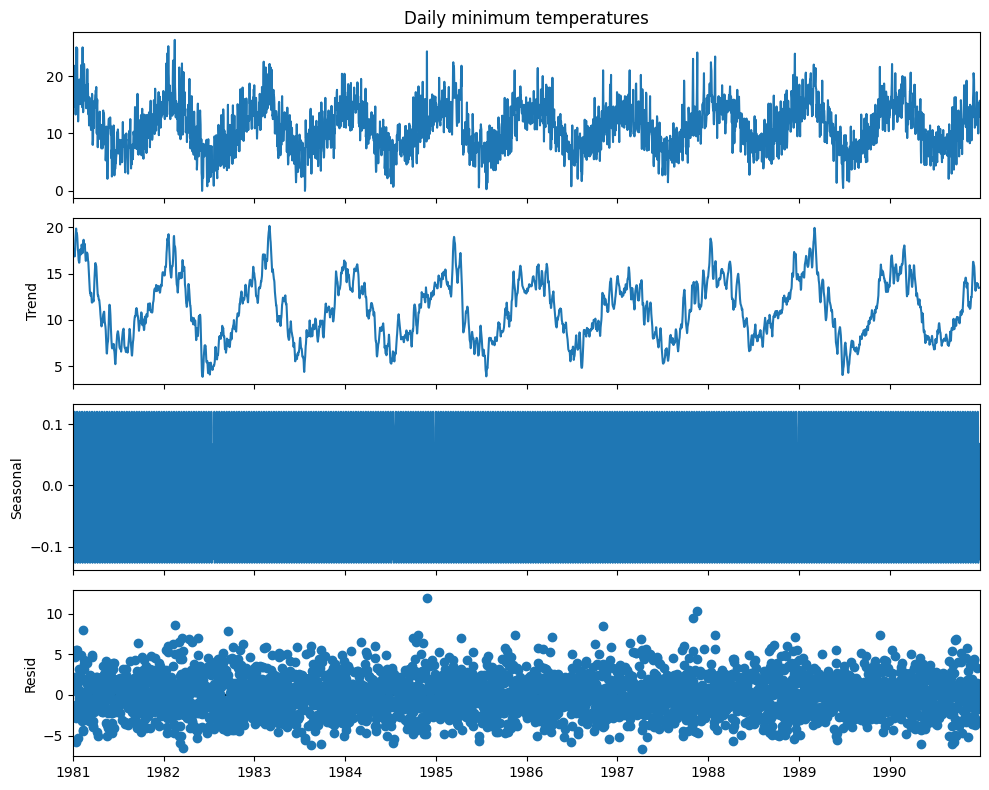

In [13]:
plot_decompose(data=ts['Daily minimum temperatures'], model='add')

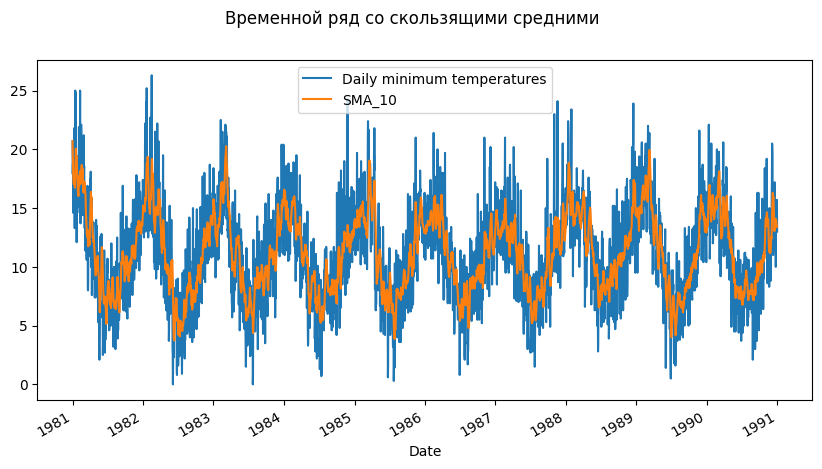

In [14]:
ts_copy = ts.copy()
# Простое скользящее среднее (SMA)
ts['SMA_10'] = ts['Daily minimum temperatures'].rolling(10, min_periods=1).mean()
fig, ax = pyplot.subplots(1, 1, sharex='col', sharey='row', figsize=(10,5))
fig.suptitle('Временной ряд со скользящими средними')
ts.plot(ax=ax, legend=True)
pyplot.show()

In [15]:
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.holtwinters import ExponentialSmoothing

In [16]:
# Целочисленная метка шкалы времени
xnum = list(range(ts_copy.shape[0]))
# Разделение выборки на обучающую и тестовую
Y = ts_copy['Daily minimum temperatures'].values
train_size = int(len(Y) * 0.7)
xnum_train, xnum_test = xnum[0:train_size], xnum[train_size:]
train, test = Y[0:train_size], Y[train_size:]
history_arima = [x for x in train]
history_es = [x for x in train]

In [17]:
# Параметры модели (p,d,q)
arima_order = (6,1,0)
# Формирование предсказаний
predictions_arima = list()
for t in range(len(test)):
    model_arima = ARIMA(history_arima, order=arima_order)
    model_arima_fit = model_arima.fit()
    yhat_arima = model_arima_fit.forecast()[0]
    predictions_arima.append(yhat_arima)
    history_arima.append(test[t])
# Вычисление метрики RMSE
error_arima = mean_squared_error(test, predictions_arima, squared=False)

In [18]:
# Формирование предсказаний
predictions_es = list()
for t in range(len(test)):
    model_es = ExponentialSmoothing(history_es)
    model_es_fit = model_es.fit()
    yhat_es = model_es_fit.forecast()[0]
    predictions_es.append(yhat_es)
    history_es.append(test[t])
# Вычисление метрики RMSE
error_es = mean_squared_error(test, predictions_es, squared=False)

In [19]:
# Ошибка прогноза
np.mean(Y), error_arima, error_es

(11.186646558815465, 2.330239912884599, 2.474388611978477)

In [20]:
ts_copy['predictions_ARIMA'] = (train_size * [np.NAN]) + list(predictions_arima)
ts_copy['predictions_HWES'] = (train_size * [np.NAN]) + list(predictions_es)

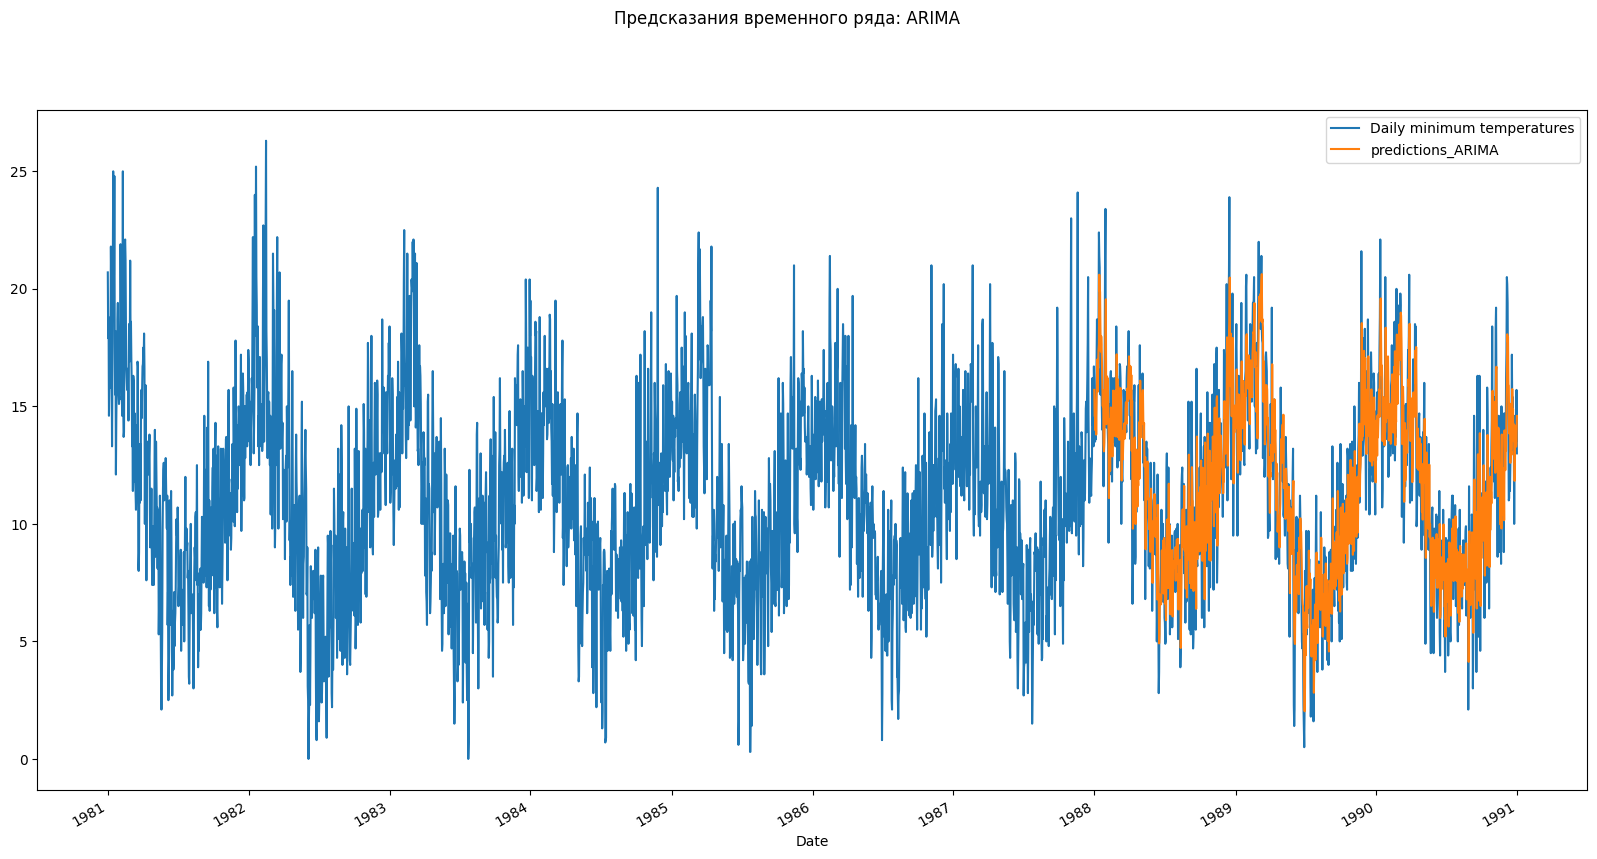

In [21]:
fig, ax = pyplot.subplots(1, 1, sharex='col', sharey='row', figsize=(20,10))
fig.suptitle('Предсказания временного ряда: ARIMA')
ts_copy.drop(["predictions_HWES"], axis=1).plot(ax=ax, legend=True)
pyplot.show()

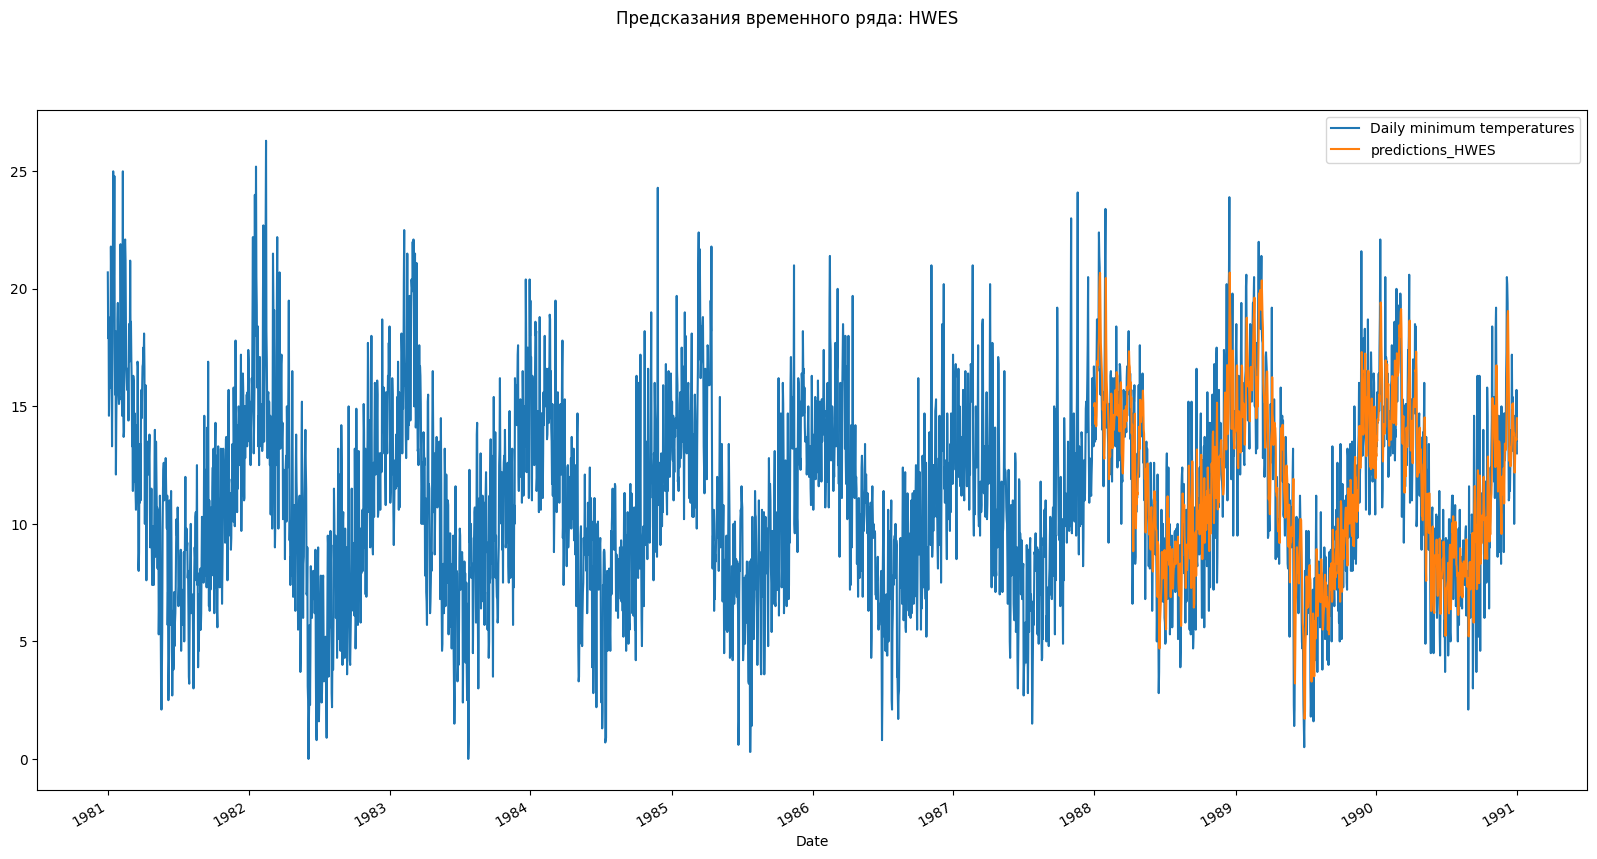

In [22]:
fig, ax = pyplot.subplots(1, 1, sharex='col', sharey='row', figsize=(20,10))
fig.suptitle('Предсказания временного ряда: HWES')
ts_copy.drop(["predictions_ARIMA"], axis=1).plot(ax=ax, legend=True)
pyplot.show()

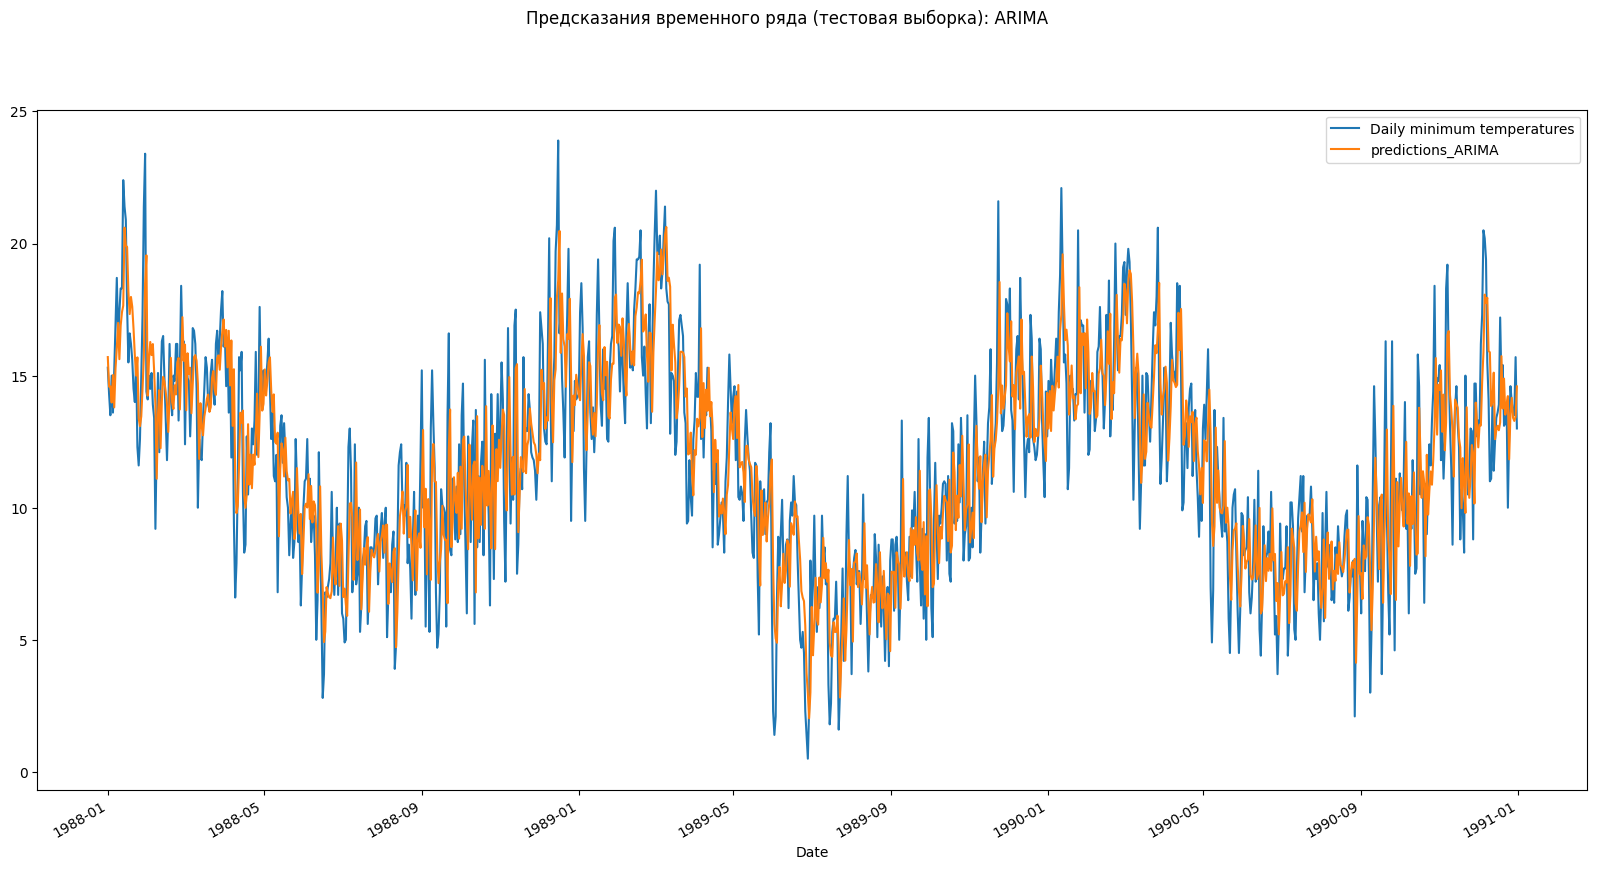

In [23]:
fig, ax = pyplot.subplots(1, 1, sharex='col', sharey='row', figsize=(20,10))
fig.suptitle('Предсказания временного ряда (тестовая выборка): ARIMA')
ts_copy.drop(["predictions_HWES"], axis=1)[train_size:].plot(ax=ax, legend=True)
pyplot.show()

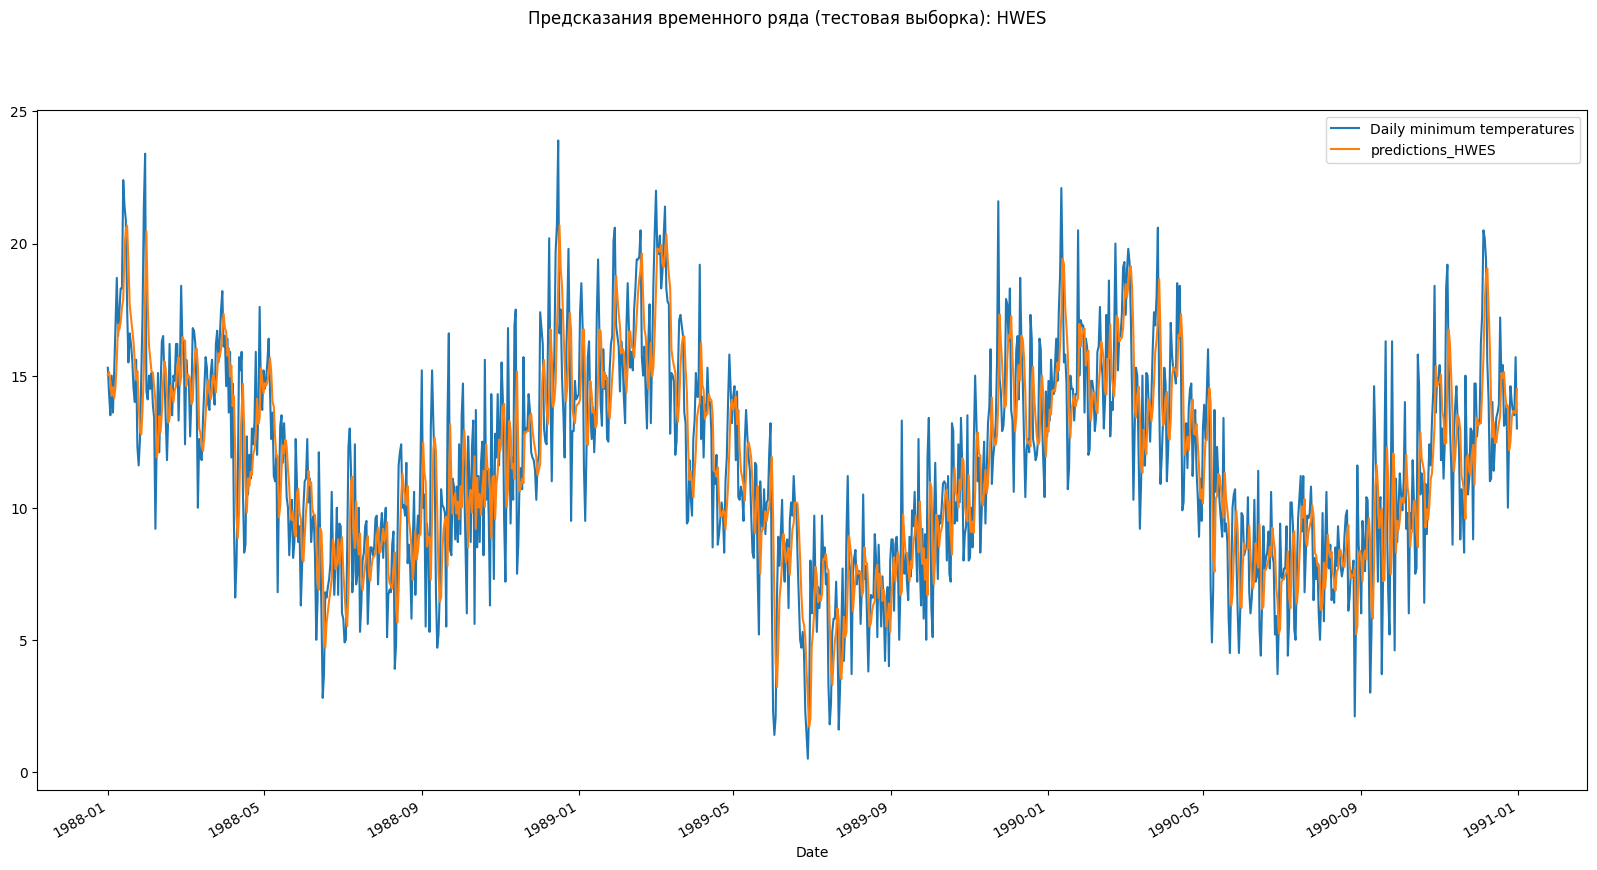

In [25]:
fig, ax = pyplot.subplots(1, 1, sharex='col', sharey='row', figsize=(20,10))
fig.suptitle('Предсказания временного ряда (тестовая выборка): HWES')
ts_copy.drop(["predictions_ARIMA"], axis=1)[train_size:].plot(ax=ax, legend=True)
pyplot.show()